In [70]:
import pandas as pd
import spacy
from sentence_transformers import SentenceTransformer
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
from wordcloud import WordCloud
from collections import Counter
import matplotlib.pyplot as plt
import pickle
import requests

In [2]:
nlp = spacy.load("en_core_web_sm")
model = SentenceTransformer('all-MiniLM-L6-v2')

### Data Cleaning

Let's merge all the files together.

In [3]:
df1 = pd.read_csv('../data/Booking_Jobs_All_220218.csv')
df2 = pd.read_csv('../data/Booking_Jobs_All_220227.csv')
df3 = pd.read_csv('../data/Booking_Jobs_All_220312.csv')

In [4]:
df = pd.concat([df1, df2, df3])

In [5]:
df

,Job Title,Job Description,Location,Team,Job ID
0,Junior Endpoints Engineer,Booking.com\r\nIt wasn’t so long ago that book...,"Manchester, United Kingdom",Engineering,NaN
1,UX Writer - B2B,"At Booking.com, data drives our decisions. Tec...","Amsterdam, Netherlands",Design & User Experience,NaN
2,Treasury Risk Specialist,Booking.com’s global treasury team is looking ...,"Amsterdam, Netherlands",Finance,NaN
3,Product Manager - Insurance - Policy Admin,About the company\r\nIt wasn’t so long ago tha...,"Manchester, United Kingdom",Product,NaN
4,Account Executive - Manchester,Account Executive - Bristol\r\nThis is a full ...,"Manchester, United Kingdom",Business Development & Support,NaN
...,...,...,...,...,...
669,Senior Java Developer,Senior Java Developer\n Who are we? \nAt Book...,"Manchester, United Kingdom",Engineering,19627.0
670,"Principal Developer, FinTech","At Booking.com, data drives our decisions. Tec...","Amsterdam, Netherlands",Engineering,19611.0
671,Senior Java Developer - Security Platform Serv...,Booking.com’s Security Platform is seeking a p...,"Amsterdam, Netherlands",Security & Infrastructure,19590.0
672,iOS Developer - App Marketing,Booking.com is the largest online travel agen...,"Amsterdam, Netherlands",Engineering,19354.0


Let's remove the non printable characters and remove the stop words.

In [6]:
def clean_text(text):
    text = ' '.join(text.split()).lower()
    text = ' '.join([word for word in text.split() if word.isalpha()])
    return text

In [7]:
df["cleaned_text"] = df["Job Description"].apply(clean_text)

In [8]:
df.head(10)

,Job Title,Job Description,Location,Team,Job ID,cleaned_text
0,Junior Endpoints Engineer,Booking.com\r\nIt wasn’t so long ago that book...,"Manchester, United Kingdom",Engineering,NaN,it so long ago that booking a trip to see the ...
1,UX Writer - B2B,"At Booking.com, data drives our decisions. Tec...","Amsterdam, Netherlands",Design & User Experience,NaN,at data drives our technology is at our and in...
2,Treasury Risk Specialist,Booking.com’s global treasury team is looking ...,"Amsterdam, Netherlands",Finance,NaN,global treasury team is looking for a treasury...
3,Product Manager - Insurance - Policy Admin,About the company\r\nIt wasn’t so long ago tha...,"Manchester, United Kingdom",Product,NaN,about the company it so long ago that booking ...
4,Account Executive - Manchester,Account Executive - Bristol\r\nThis is a full ...,"Manchester, United Kingdom",Business Development & Support,NaN,account executive bristol this is a full time ...
5,Senior Android Developer - Accommodations,"About the job\r\nAt Booking.com, data drives o...","Amsterdam, Netherlands",Engineering,NaN,about the job at data drives our technology is...
6,Account Executive - Nairobi (Amharic Speaker),The Company\r\n\r\nIt wasn’t so long ago that ...,"Nairobi, Kenya",Business Development & Support,NaN,the company it so long ago that booking a trip...
7,Account Executive - Nairobi (French Speaker),The Company\r\n\r\nIt wasn’t so long ago that ...,"Nairobi, Kenya",Business Development & Support,NaN,the company it so long ago that booking a trip...
8,"Client Manager, FinTech",Our brand new FinTech business unit – with tea...,"Amsterdam, Netherlands",IT Services,NaN,our brand new fintech business unit with teams...
9,Senior Data Scientist - Accommodations,Booking.com is looking for data savvy professi...,"Amsterdam, Netherlands",Data Science & Analytics,NaN,is looking for data savvy professionals to joi...


In [9]:
df['Team'].value_counts()

Team
Engineering                       582
Business Development & Support    333
People                            219
Security & Infrastructure         156
Design & User Experience          121
Product                           107
Data Science & Analytics          102
Marketing & Communications        102
Customer Service                   79
Leadership                         72
Finance & Legal                    53
Finance                            29
IT Services                        19
Legal & Public Affairs             11
Name: count, dtype: int64

Let's remove the stop words. 

In [10]:
def remove_stopwords(text):
    doc = nlp(text)
    return ' '.join(token.text for token in doc if not token.is_stop)

In [11]:
df["cleaned_text"] = df["cleaned_text"].apply(remove_stopwords)

Let's lemmatise text

In [12]:
def lemmatize_text(text):
    doc = nlp(text)
    return ' '.join(token.lemma_ for token in doc)

In [13]:
df["cleaned_text"] = df["cleaned_text"].apply(lemmatize_text)

Let's remove some custom stop words

In [14]:
combined_string = " ".join([sentence for sentence in df['cleaned_text'].values])
Counter(combined_string.split()).most_common(50)

[('experience', 11499),
 ('work', 11135),
 ('team', 9605),
 ('business', 8525),
 ('product', 7522),
 ('partner', 4824),
 ('datum', 4686),
 ('opportunity', 4505),
 ('strong', 4479),
 ('drive', 4427),
 ('new', 4332),
 ('customer', 3988),
 ('support', 3889),
 ('technology', 3428),
 ('travel', 3275),
 ('people', 3118),
 ('ability', 3116),
 ('development', 3111),
 ('lead', 3012),
 ('build', 2964),
 ('technical', 2950),
 ('management', 2937),
 ('include', 2921),
 ('responsible', 2904),
 ('develop', 2893),
 ('manage', 2851),
 ('ensure', 2844),
 ('company', 2782),
 ('design', 2768),
 ('good', 2747),
 ('service', 2714),
 ('create', 2695),
 ('impact', 2658),
 ('skill', 2641),
 ('world', 2631),
 ('stakeholder', 2607),
 ('solution', 2600),
 ('deliver', 2484),
 ('environment', 2457),
 ('knowledge', 2400),
 ('project', 2391),
 ('need', 2374),
 ('provide', 2314),
 ('year', 2234),
 ('help', 2228),
 ('engineering', 2214),
 ('role', 2213),
 ('manager', 2184),
 ('accommodation', 2171),
 ('understand', 21

In [15]:
custom_stopwords = [
    'experience', 'work', 'opportunity', 'strong', 'ability', 'include', 'responsible', 'skill', 'knowledge', 'ability', 
    'company', 'good', 'world', 'year', 'understand'
]

In [16]:
def remove_custom_stopwords(text):
    text = " ".join([word for word in text.split() if word not in custom_stopwords])
    return text

In [17]:
df['cleaned_text'] = df['cleaned_text'].apply(remove_custom_stopwords)

In [18]:
df.head(10)

,Job Title,Job Description,Location,Team,Job ID,cleaned_text
0,Junior Endpoints Engineer,Booking.com\r\nIt wasn’t so long ago that book...,"Manchester, United Kingdom",Engineering,NaN,long ago book trip eiffel stroll new iconic ma...
1,UX Writer - B2B,"At Booking.com, data drives our decisions. Tec...","Amsterdam, Netherlands",Design & User Experience,NaN,datum drive technology innovation line code th...
2,Treasury Risk Specialist,Booking.com’s global treasury team is looking ...,"Amsterdam, Netherlands",Finance,NaN,global treasury team look treasury risk manage...
3,Product Manager - Insurance - Policy Admin,About the company\r\nIt wasn’t so long ago tha...,"Manchester, United Kingdom",Product,NaN,long ago book trip eiffel stroll new iconic ma...
4,Account Executive - Manchester,Account Executive - Bristol\r\nThis is a full ...,"Manchester, United Kingdom",Business Development & Support,NaN,account executive bristol time position base a...
5,Senior Android Developer - Accommodations,"About the job\r\nAt Booking.com, data drives o...","Amsterdam, Netherlands",Engineering,NaN,job data drive technology innovation line code...
6,Account Executive - Nairobi (Amharic Speaker),The Company\r\n\r\nIt wasn’t so long ago that ...,"Nairobi, Kenya",Business Development & Support,NaN,long ago book trip eiffel stroll new iconic ma...
7,Account Executive - Nairobi (French Speaker),The Company\r\n\r\nIt wasn’t so long ago that ...,"Nairobi, Kenya",Business Development & Support,NaN,long ago book trip eiffel stroll new iconic ma...
8,"Client Manager, FinTech",Our brand new FinTech business unit – with tea...,"Amsterdam, Netherlands",IT Services,NaN,brand new fintech business unit team amsterdam...
9,Senior Data Scientist - Accommodations,Booking.com is looking for data savvy professi...,"Amsterdam, Netherlands",Data Science & Analytics,NaN,look datum savvy professional join team datum ...


In [19]:
df["Job Description"].values

array(["Booking.com\r\nIt wasn’t so long ago that booking a trip to see the Eiffel Tower, stroll down New York’s iconic Madison Avenue or feel the sand between our toes on Copacabana Beach was simply a matter of a few taps on our smartphone.\r\nIn fact, that’s what we do at Booking.com. We make it easier for everyone to experience the world. And while that world might feel a little farther away right now, we’re busy preparing for when the world is ready to travel once more.\r\nAcross our offices worldwide, we continue to innovate. To solve for some of the most complex challenges in travel and technology, and to plan for the exciting developments that lie ahead. With strategic long-term investments into what we believe the future of travel can be, we are opening up new career opportunities that will have a strong impact on our mission.\r\nWe are united in the belief that our very human desire to explore the planet’s beauty and discover more about other people and cultures will endure. T

In [20]:
df["cleaned_text"].values

array(['long ago book trip eiffel stroll new iconic madison avenue feel sand toe copacabana beach simply matter tap easy feel little far away right busy prepare ready travel office continue solve complex challenge travel plan exciting development lie strategic investment believe future travel open new career impact united belief human desire explore beauty discover people culture waiting service want service positive impact entire late technology global deployment look talented support technician join services department build maintain corporate technology workforce need deliver great product saas collaboration productivity communication vdi video voice itsm plethora bespoke develop service organization seek talented energetic support team lead assist enable provide excellent user analyze address relate problem look solution automate improve junior endpoint engineer book employee base diverse globally rely different technology order achieve order provide colleague well secure compliant

### Let's Find The Number Of Clusters

We will do embedding with sentence transformers first. 

In [21]:
text_embeddings = model.encode(df["cleaned_text"].values, show_progress_bar=True)

Batches: 100%|██████████| 63/63 [00:07<00:00,  8.26it/s]


Let's find the shape of it. 

In [22]:
text_embeddings.shape

(1985, 384)

We will use the silhouette score to find the optimal number of clusters. 

In [24]:
silhouette_scores = []
for k in range(2, 15):  # Test different numbers of clusters
    kmeans = KMeans(n_clusters=k, random_state=42).fit(text_embeddings)
    silhouette_scores.append(silhouette_score(text_embeddings, kmeans.labels_))

In [25]:
optimal_k = silhouette_scores.index(max(silhouette_scores)) + 2  # Best k based on silhouette scores
print(f'Optimal k is {optimal_k}')

Optimal k is 12


### Fit The Clustering

Let's fit the clustering model

In [26]:
kmeans = KMeans(n_clusters=optimal_k, random_state=42).fit(text_embeddings)

In [27]:
df['cluster'] = kmeans.labels_

In [28]:
df.head(10)

,Job Title,Job Description,Location,Team,Job ID,cleaned_text,cluster
0,Junior Endpoints Engineer,Booking.com\r\nIt wasn’t so long ago that book...,"Manchester, United Kingdom",Engineering,NaN,long ago book trip eiffel stroll new iconic ma...,3
1,UX Writer - B2B,"At Booking.com, data drives our decisions. Tec...","Amsterdam, Netherlands",Design & User Experience,NaN,datum drive technology innovation line code th...,9
2,Treasury Risk Specialist,Booking.com’s global treasury team is looking ...,"Amsterdam, Netherlands",Finance,NaN,global treasury team look treasury risk manage...,1
3,Product Manager - Insurance - Policy Admin,About the company\r\nIt wasn’t so long ago tha...,"Manchester, United Kingdom",Product,NaN,long ago book trip eiffel stroll new iconic ma...,3
4,Account Executive - Manchester,Account Executive - Bristol\r\nThis is a full ...,"Manchester, United Kingdom",Business Development & Support,NaN,account executive bristol time position base a...,8
5,Senior Android Developer - Accommodations,"About the job\r\nAt Booking.com, data drives o...","Amsterdam, Netherlands",Engineering,NaN,job data drive technology innovation line code...,9
6,Account Executive - Nairobi (Amharic Speaker),The Company\r\n\r\nIt wasn’t so long ago that ...,"Nairobi, Kenya",Business Development & Support,NaN,long ago book trip eiffel stroll new iconic ma...,3
7,Account Executive - Nairobi (French Speaker),The Company\r\n\r\nIt wasn’t so long ago that ...,"Nairobi, Kenya",Business Development & Support,NaN,long ago book trip eiffel stroll new iconic ma...,3
8,"Client Manager, FinTech",Our brand new FinTech business unit – with tea...,"Amsterdam, Netherlands",IT Services,NaN,brand new fintech business unit team amsterdam...,9
9,Senior Data Scientist - Accommodations,Booking.com is looking for data savvy professi...,"Amsterdam, Netherlands",Data Science & Analytics,NaN,look datum savvy professional join team datum ...,1


### Find Top Keywords And Display The Wordcloud

Let's find the most frequent words, department in each cluster and display the wordcloud

In [57]:
def keywords_and_wordcloud(cluster_df):
    # join all the text of the cleaned text into one string
    combined_string = " ".join([sentence for sentence in cluster_df['cleaned_text'].values])
    word_counter = Counter(combined_string.split())
    most_common_words = word_counter.most_common(20)
    top_teams = cluster_df['Team'].value_counts(normalize=True)[0:3].to_dict()

    wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='viridis').generate(combined_string)
    return most_common_words, wordcloud, top_teams

In [59]:
common_words, wordcloud, top_teams = keywords_and_wordcloud(df[df['cluster'] == 0])

In [60]:
print(f'Common Words: {common_words}')
print(f'Top Teams: {top_teams}')

Common Words: [('team', 1303), ('product', 967), ('technology', 626), ('engineering', 599), ('customer', 514), ('great', 512), ('quality', 502), ('new', 493), ('understanding', 465), ('business', 457), ('technical', 450), ('development', 438), ('travel', 403), ('drive', 381), ('practice', 377), ('datum', 367), ('deliver', 363), ('design', 339), ('solution', 332), ('trip', 318)]
Top Teams: {'Engineering': 0.7947019867549668, 'Product': 0.11258278145695365, 'Security & Infrastructure': 0.039735099337748346}


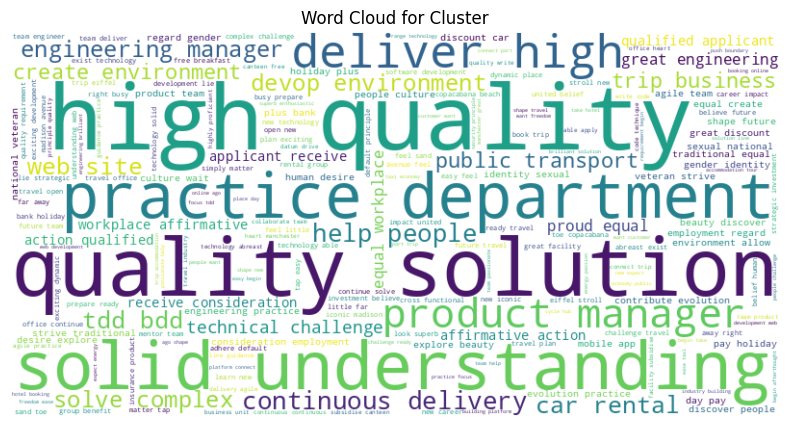

In [32]:
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title(f'Word Cloud for Cluster')
plt.show()

In [63]:
df.to_parquet('../models/df.parquet')

In [66]:
with open('../models/model.pkl', "wb") as file:
    pickle.dump(kmeans, file)

### Let's test the API

Now let's test the API

In [71]:
df.iloc[0]

Job Title                                  Junior Endpoints Engineer
Job Description    Booking.com\r\nIt wasn’t so long ago that book...
Location                                  Manchester, United Kingdom
Team                                                     Engineering
Job ID                                                           NaN
cleaned_text       long ago book trip eiffel stroll new iconic ma...
cluster                                                            3
Name: 0, dtype: object

In [96]:
url = "http://localhost:8000/predict/"

payload = {
    "text": df.iloc[0]['Job Description']
}

# payload = {
#     "text": "Hello, world!"
# }

response = requests.post(url, json=payload)
# print(response.json())
print(response.text)

{"cluster_id":3,"top_keywords":["partner","travel","business","product","new","team","people","feel","development","manage","customer","support","impact","create","solve","lead","career","value","account","open"],"predicted_teams":{"Business Development & Support":0.5327510917030568,"Engineering":0.2838427947598253,"Product":0.043668122270742356}}


In [95]:
print(response.json())

{'cluster_id': 3}
